In [1]:
# In[1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configurações de plot
plt.style.use('seaborn-v0_8-darkgrid')

# Caminhos dos arquivos
DATA_PATH = '../data'  # Ajuste conforme sua estrutura
DATA_FILE = 'dados_transacao_26173.csv'  # Ajuste o nome do seu arquivo CSV

full_path = os.path.join(DATA_PATH, DATA_FILE)

Importing plotly failed. Interactive plots will not work.


In [2]:
# In[2]: Carregando os dados
df = pd.read_csv(full_path, sep=',', decimal='.', parse_dates=['Data'], dayfirst=True)

print(df.head())
print(df.info())

# Agrupar os valores por data para obter a média diária
col_valor = 'ValorUnitario'
col_data = 'Data'

daily = df.groupby(col_data)[col_valor].mean().reset_index()
daily.columns = ['ds', 'y']  # Renomear colunas para o formato esperado pelo Prophet

print(daily.head())

   CodigoVenda        Data             DataHora Status  VendaCancelada  \
0      2263035  2019-01-02  2019-01-02 08:36:25      f               0   
1      2263063  2019-01-02  2019-01-02 09:01:27      f               0   
2      2263067  2019-01-02  2019-01-02 09:06:07      f               0   
3      2263151  2019-01-02  2019-01-02 09:55:52      f               0   
4      2263159  2019-01-02  2019-01-02 10:01:20      f               0   

   TotalPedido  DescontoGeral  AcrescimoGeral  TotalCusto  CodigoProduto  ...  \
0        58.08            0.0             0.0       27.30          26173  ...   
1        40.05            0.0             0.0       29.45          26173  ...   
2        34.75            0.0             0.0       26.94          26173  ...   
3       210.10            0.0             0.0      146.63          26173  ...   
4        96.72            0.0             0.0       60.43          26173  ...   

   ValorCustoGerencial  CodigoFornecedor  CodigoKitPrincipal  \
0   

In [12]:
print(df.head())
print(df.info())
print(df['ValorUnitario'].describe())  # Estatísticas básicas da coluna ValorUnitario

# In[3]: Criar intervalo de datas contínuo e preencher valores ausentes
data_inicial = daily['ds'].min()
data_final = daily['ds'].max()

# Criar intervalo contínuo de datas
full_range = pd.date_range(start=data_inicial, end=data_final, freq='D')

# Garantir que apenas datas ausentes sejam adicionadas
daily = daily.set_index('ds').reindex(full_range).reset_index()
daily.columns = ['ds', 'y']

# Preencher os valores ausentes sem alterar os existentes
if daily['y'].isna().all():
    print("Todos os valores em 'y' estão ausentes. Substituindo por 0.")
    daily['y'] = 0  # Ou usar outra estratégia
else:
    daily['y'] = daily['y'].fillna(method='ffill')  # Preenchimento correto

# Verificar os dados após preenchimento
print(daily.head())
print(daily.tail())
print(daily.isna().sum())

   CodigoVenda        Data             DataHora Status  VendaCancelada  \
0      2263035  2019-01-02  2019-01-02 08:36:25      f               0   
1      2263063  2019-01-02  2019-01-02 09:01:27      f               0   
2      2263067  2019-01-02  2019-01-02 09:06:07      f               0   
3      2263151  2019-01-02  2019-01-02 09:55:52      f               0   
4      2263159  2019-01-02  2019-01-02 10:01:20      f               0   

   TotalPedido  DescontoGeral  AcrescimoGeral  TotalCusto  CodigoProduto  ...  \
0        58.08            0.0             0.0       27.30          26173  ...   
1        40.05            0.0             0.0       29.45          26173  ...   
2        34.75            0.0             0.0       26.94          26173  ...   
3       210.10            0.0             0.0      146.63          26173  ...   
4        96.72            0.0             0.0       60.43          26173  ...   

   ValorCustoGerencial  CodigoFornecedor  CodigoKitPrincipal  \
0   

/tmp/ipykernel_1634179/303610049.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily['y'] = daily['y'].fillna(method='ffill')  # Preenchimento correto


          ds  y
0 2019-01-02  0
1 2019-01-03  0
2 2019-01-04  0
3 2019-01-05  0
4 2019-01-06  0
             ds  y
1820 2023-12-27  0
1821 2023-12-28  0
1822 2023-12-29  0
1823 2023-12-30  0
1824 2023-12-31  0
ds    0
y     0
dtype: int64


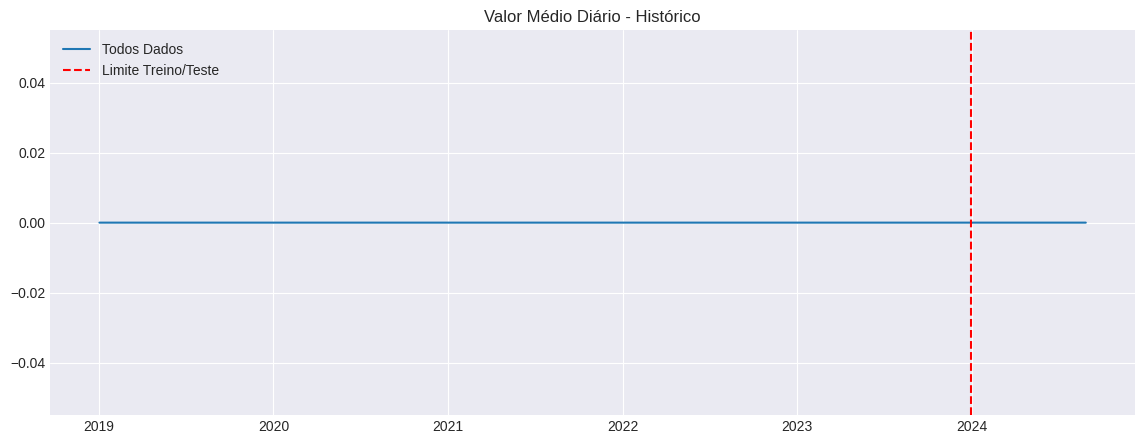

In [9]:
# In[4]: Separar dados em treino e teste
train_end_date = datetime(2023, 12, 31)
test_end_date = datetime(2024, 3, 30)

train_data = daily[daily['ds'] <= train_end_date]
test_data = daily[(daily['ds'] > train_end_date) & (daily['ds'] <= test_end_date)]

print(train_data.head())
print(train_data.tail())
print(train_data.isna().sum())

# Visualização dos dados
plt.figure(figsize=(14, 5))
plt.plot(daily['ds'], daily['y'], label='Todos Dados')
plt.axvline(x=train_end_date, color='red', linestyle='--', label='Limite Treino/Teste')
plt.title('Valor Médio Diário - Histórico')
plt.legend()
plt.show()

In [5]:
# In[5]: Treinamento do modelo Prophet
model = Prophet()
model.fit(train_data)

# Criar datas futuras para previsão
future = model.make_future_dataframe(periods=len(test_data), freq='D')

# Fazer a previsão
forecast = model.predict(future)

# Visualizar componentes
model.plot_components(forecast)
plt.show()

ValueError: Dataframe has less than 2 non-NaN rows.

In [ ]:
# In[6]: Ajustar os dados de previsão para avaliação
forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').loc[test_data['ds']]

# Métricas de avaliação
mae = mean_absolute_error(test_data['y'], forecast_filtered['yhat'])
mse = mean_squared_error(test_data['y'], forecast_filtered['yhat'])
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

In [ ]:
# In[7]: Comparação entre valores reais e previstos
plt.figure(figsize=(14, 5))
plt.plot(test_data['ds'], test_data['y'], label='Valor Real')
plt.plot(test_data['ds'], forecast_filtered['yhat'], label='Predição (Prophet)')
plt.title('Comparação entre Real e Previsto (Teste)')
plt.legend()
plt.show()

# Salvar resultados em um arquivo CSV (opcional)
resultados = pd.DataFrame({
    'Data': test_data['ds'],
    'Valor Real': test_data['y'],
    'Predição': forecast_filtered['yhat']
})
resultados.to_csv('resultados_prophet.csv', index=False)
print("Resultados salvos em 'resultados_prophet.csv'.")